In [59]:
import matplotlib
from matplotlib import pylab
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.dpi'] = 80
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (6, 4),
         'axes.labelsize': 'xx-large',
         'axes.titlesize': 'xx-large',
         'xtick.labelsize': 'x-large',
         'ytick.labelsize': 'x-large',
         'figure.facecolor': 'w'}
pylab.rcParams.update(params)
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

import h5py
import numpy as np
import os
import sys
import torch
import yaml
from scipy.optimize import curve_fit

%load_ext autoreload
%autoreload 2
sys.path.insert(1, '../code')
from geometric_features import GeometricFeaturizer, geo_name
from scalar_features import ScalarFeaturizer, scalar_name
from read_halos import SimulationReader
from fit import LinearFitter
from neural_net import NeuralNet, NNFitter
import plotter
import utils
import feature_importance

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
sim_name = 'TNG100-1'
#sim_name = 'TNG50-4'
sim_name_dark = f'{sim_name}-Dark'

halo_tag = ''
geo_tag = ''
scalar_tag = ''
mass_multiplier = 1e10
log_mass_shift = 10

## Load features

In [3]:
fn_halo_config = f'../configs/halos_{sim_name}{halo_tag}.yaml'
print(fn_halo_config)
fn_geo_config = f'../configs/geo_{sim_name}{halo_tag}{geo_tag}.yaml'
print(fn_geo_config)
fn_scalar_config = f'../configs/scalar_{sim_name}{halo_tag}{geo_tag}{scalar_tag}.yaml'
print(fn_scalar_config)

../configs/halos_TNG100-1.yaml
../configs/geo_TNG100-1.yaml
../configs/scalar_TNG100-1.yaml


In [4]:
with open(fn_scalar_config, 'r') as file:
    scalar_params = yaml.safe_load(file)
scp = scalar_params['scalar']

fn_geo_config = scalar_params['geo']['fn_geo_config']
with open(fn_geo_config, 'r') as file:
    geo_params = yaml.safe_load(file)
gp = geo_params['geo']

with open(fn_halo_config, 'r') as file:
    halo_params = yaml.safe_load(file)

fn_dark_halo_arr = halo_params['halo']['fn_dark_halo_arr']

In [5]:
geo_featurizer = GeometricFeaturizer()
geo_featurizer.load_features(gp['fn_geo_features'])

In [6]:
sim_reader = SimulationReader(halo_params['sim']['base_dir'], sim_name, sim_name_dark, 
                              halo_params['sim']['snap_num_str'])
sim_reader.load_dark_halo_arr(fn_dark_halo_arr)
sim_reader.read_simulations()

In [7]:
mrv_for_rescaling = utils.get_mrv_for_rescaling(sim_reader, scp['mrv_names_for_rescaling'])
scalar_featurizer = ScalarFeaturizer(geo_featurizer.geo_feature_arr,
                        n_groups_rebin=scp['n_groups_rebin'], 
                        transform_pseudotensors=scp['transform_pseudotensors'], 
                        mrv_for_rescaling=mrv_for_rescaling)

Rebinning geometric features
Transforming pseudotensors
Rescaling geometric features


In [8]:
x_features_extra = np.log10(mrv_for_rescaling).T

In [ ]:
print('loading')
scalar_featurizer.load_features(scp['fn_scalar_features'])
print('loaded')

loading


## Other features

In [ ]:
x_dict = {}
x_extra_dict = {}

In [ ]:
x_dict['scalars'] = scalar_featurizer.scalar_features
x_extra_dict['scalars'] = x_features_extra

x_dict['geos'] = utils.geo_feature_arr_to_values(scalar_featurizer.geo_feature_arr)
x_extra_dict['geos'] = x_features_extra

x_dict['mrv'] = x_features_extra
x_extra_dict['mrv'] = None


catalog_feature_names = ['M200c', 'c200c', 'a_form']
# if feature_mode=='catalog_mergers_noaform':
#     catalog_feature_names = ['M200c', 'c200c']
sim_reader.get_structure_catalog_features(catalog_feature_names)
x = sim_reader.x_catalog_features
x_dict['catalog'] = x
x_extra_dict['catalog'] = None

catalog_feature_names = ['M200c', 'c200c']
sim_reader.get_structure_catalog_features(catalog_feature_names)
x = sim_reader.x_catalog_features
if feature_mode=='catalog_mergers':
    properties_merger = ['num_mergers', 'num_major_mergers', 'ratio_last_major_merger']
    for prop in properties_merger:
        vals = utils.get_y_vals(prop, sim_reader)
        vals = np.atleast_2d(vals).T
        x = np.concatenate((x, vals), axis=1)
 
        
x_extra = None

properties_merger = ['num_mergers', 'num_major_mergers', 'ratio_last_major_merger']
for prop in properties_merger:
    vals = utils.get_y_vals(prop, sim_reader)
    vals = np.atleast_2d(vals).T
    x = np.concatenate((x, vals), axis=1)
x_dict['catalog_mergers'] = x
x_extra_dict['catalog_mergers'] = None

## Gather properties

In [ ]:
sim_reader.add_catalog_property_to_halos('m200m')
m_200m = np.array([dark_halo.catalog_properties['m200m'] for dark_halo in sim_reader.dark_halo_arr])
log_m_200m = np.log10(m_200m)

## Split train-val-test

In [ ]:
frac_train = 0.70
frac_val = 0.15
frac_test = 0.15

random_ints = np.array([dark_halo.random_int for dark_halo in sim_reader.dark_halo_arr])
idx_train, idx_val, idx_test = utils.split_train_val_test(random_ints, frac_train=frac_train, 
                                                      frac_val=frac_val, frac_test=frac_test)

In [ ]:
x_test = scalar_featurizer.scalar_features[idx_test]
y_test_current = None
x_test_extra = x_features_extra[idx_test]

# Explore color

In [23]:
phot_file = f'{sim_reader.tng_path_hydro}/postprocessing/stellar_photometry/Subhalo_StellarPhot_p07c_cf00dust_res_conv_ns1_rad30pkpc_{sim_reader.snap_num_str}.hdf5'
f_phot = h5py.File(phot_file)
print(f_phot.keys())
phot = f_phot['Subhalo_StellarPhot_p07c_cf00dust_res_conv_ns1_rad30pkpc']
print(phot.shape)
# columns: sdss_u, sdss_g, sdss_r, sdss_i, sdss_z, wfc_acs_f606w, des_y, jwst_f150w

<KeysViewHDF5 ['Subhalo_StellarPhot_p07c_cf00dust_res_conv_ns1_rad30pkpc', 'subhaloIDs']>
(4371211, 8, 12)


In [35]:
gband_all = phot[:,1,0]

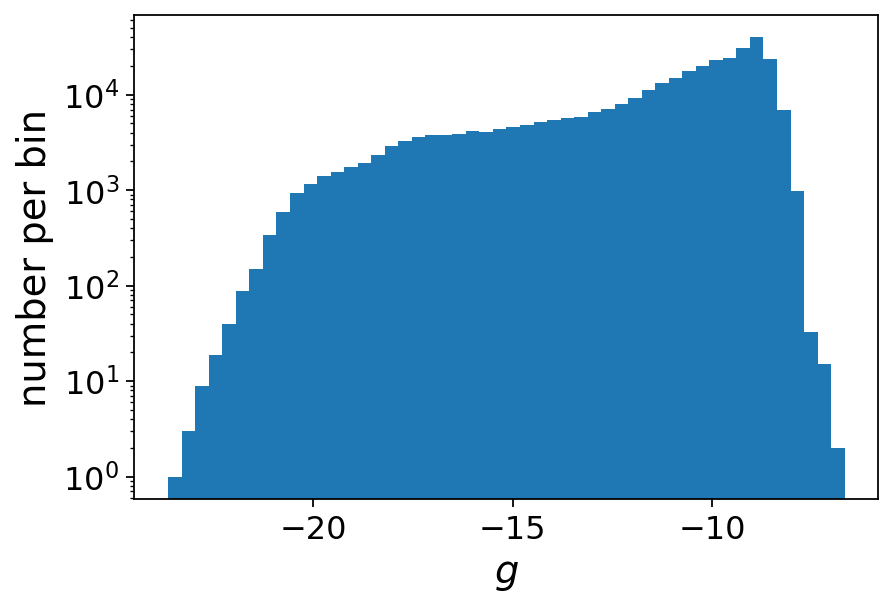

In [36]:
plt.hist(gband_all, bins=50)
plt.xlabel(r'$g$')
plt.ylabel('number per bin')
plt.yscale('log')

In [28]:
sim_reader.add_catalog_property_to_halos('gband')
gband = np.array([halo.catalog_properties['gband'] for halo in sim_reader.dark_halo_arr])

<KeysViewHDF5 ['Subhalo_StellarPhot_p07c_cf00dust_res_conv_ns1_rad30pkpc', 'subhaloIDs']>


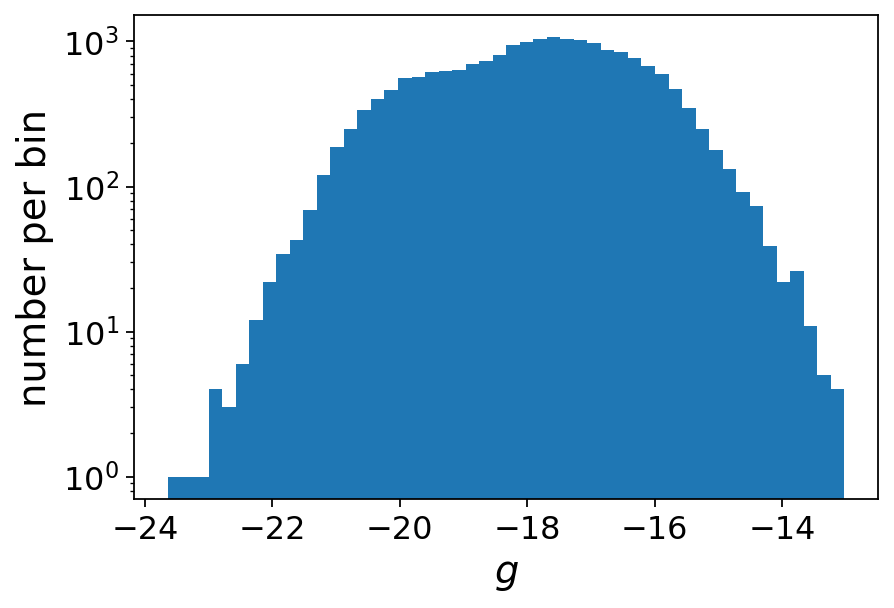

In [32]:
plt.hist(gband, bins=50)
plt.xlabel(r'$g$')
plt.ylabel('number per bin')
plt.yscale('log')

In [37]:
gminusi_all = phot[:,1,0] - phot[:,3,0]

In [38]:
sim_reader.add_catalog_property_to_halos('gband_minus_iband')
gminusi = np.array([halo.catalog_properties['gband_minus_iband'] for halo in sim_reader.dark_halo_arr])

<KeysViewHDF5 ['Subhalo_StellarPhot_p07c_cf00dust_res_conv_ns1_rad30pkpc', 'subhaloIDs']>


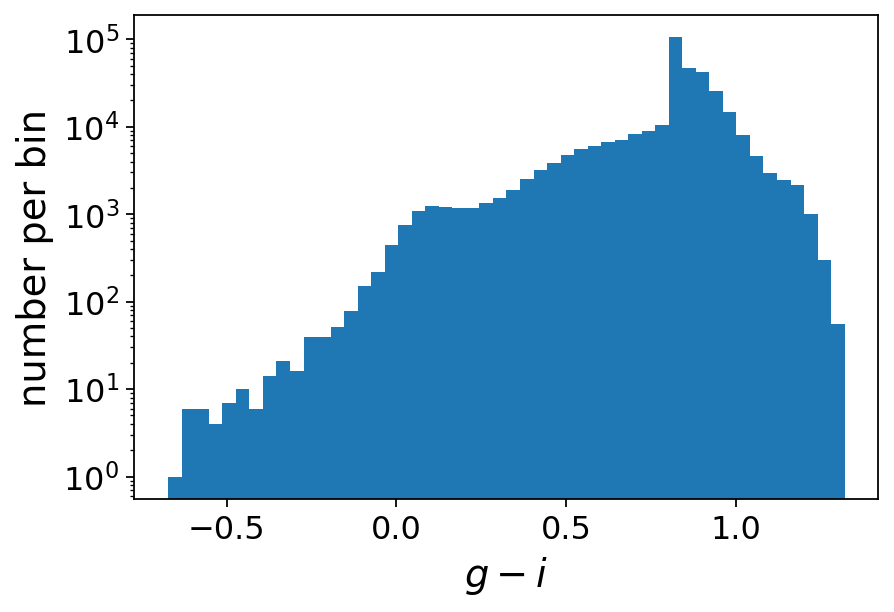

In [39]:
plt.hist(gminusi_all, bins=50)
plt.xlabel(r'$g - i$')
plt.ylabel('number per bin')
plt.yscale('log')

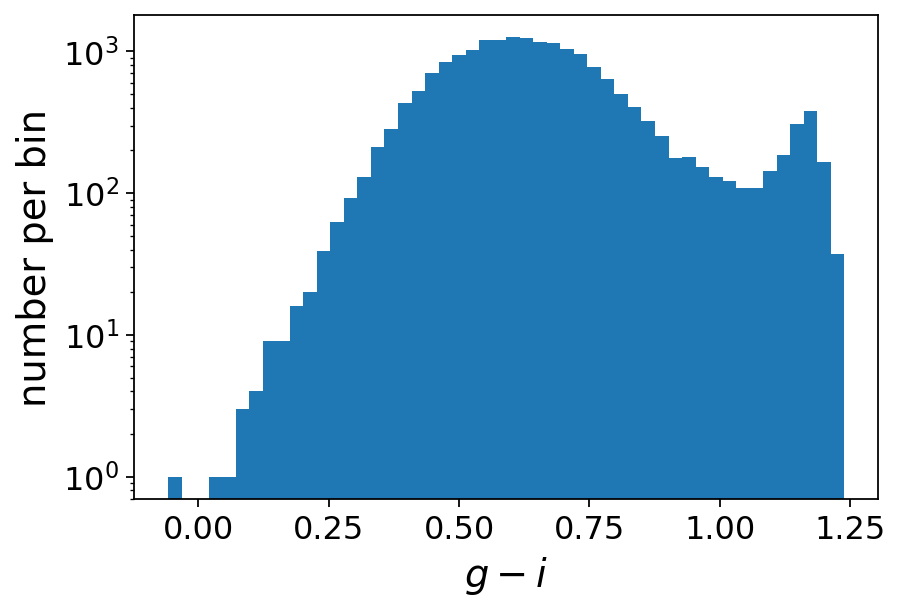

In [40]:
plt.hist(gminusi, bins=50)
plt.xlabel(r'$g - i$')
plt.ylabel('number per bin')
plt.yscale('log')

# Prediction

## G-band

In [46]:
y_label_name = 'gband'

In [51]:
fit_tag = f'_{y_label_name}_nn_scalars_epochs500_lr5e-05_hs128'
fn_model = f'../models/models_{sim_name}/model_{sim_name}{halo_tag}{geo_tag}{scalar_tag}{fit_tag}.pt'

In [52]:
y = utils.get_y_vals(y_label_name, sim_reader)
y_test = y[idx_test]

<KeysViewHDF5 ['Subhalo_StellarPhot_p07c_cf00dust_res_conv_ns1_rad30pkpc', 'subhaloIDs']>


In [53]:
nnfitter = NNFitter()
nnfitter.load_model(fn_model)

In [54]:
import torch
model_checkpoint = torch.load(fn_model)

88 0.07614766818904571


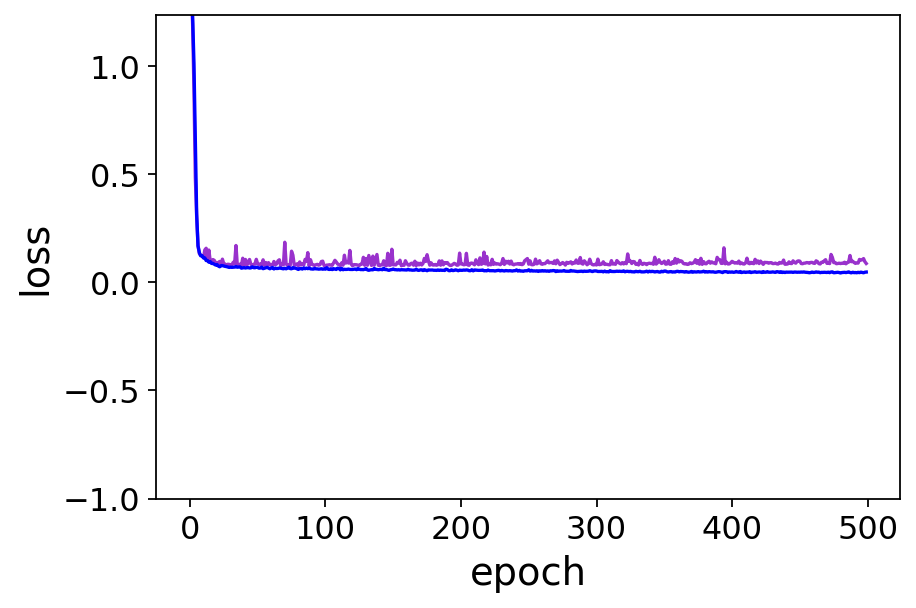

In [55]:
plt.plot(nnfitter.loss_valid, color='darkorchid', label='Validation')
plt.plot(nnfitter.loss_train, color='blue', label='Training')
plt.xlabel('epoch')
plt.ylabel('loss')
#plt.ylim(0,300)
plt.ylim(-1, nnfitter.loss_train[2])
print(np.argmin(nnfitter.loss_valid), np.min(nnfitter.loss_valid))

In [56]:
y_pred = nnfitter.predict(x_test, y_current=y_test_current, x_extra=x_test_extra)

/home/ksf293/equivariant-cosmology/notebooks/../code/utils.py:327: UserWarning: Trying to register the cmap 'shiftedcmap' which already exists.
  plt.register_cmap(cmap=newcmap)


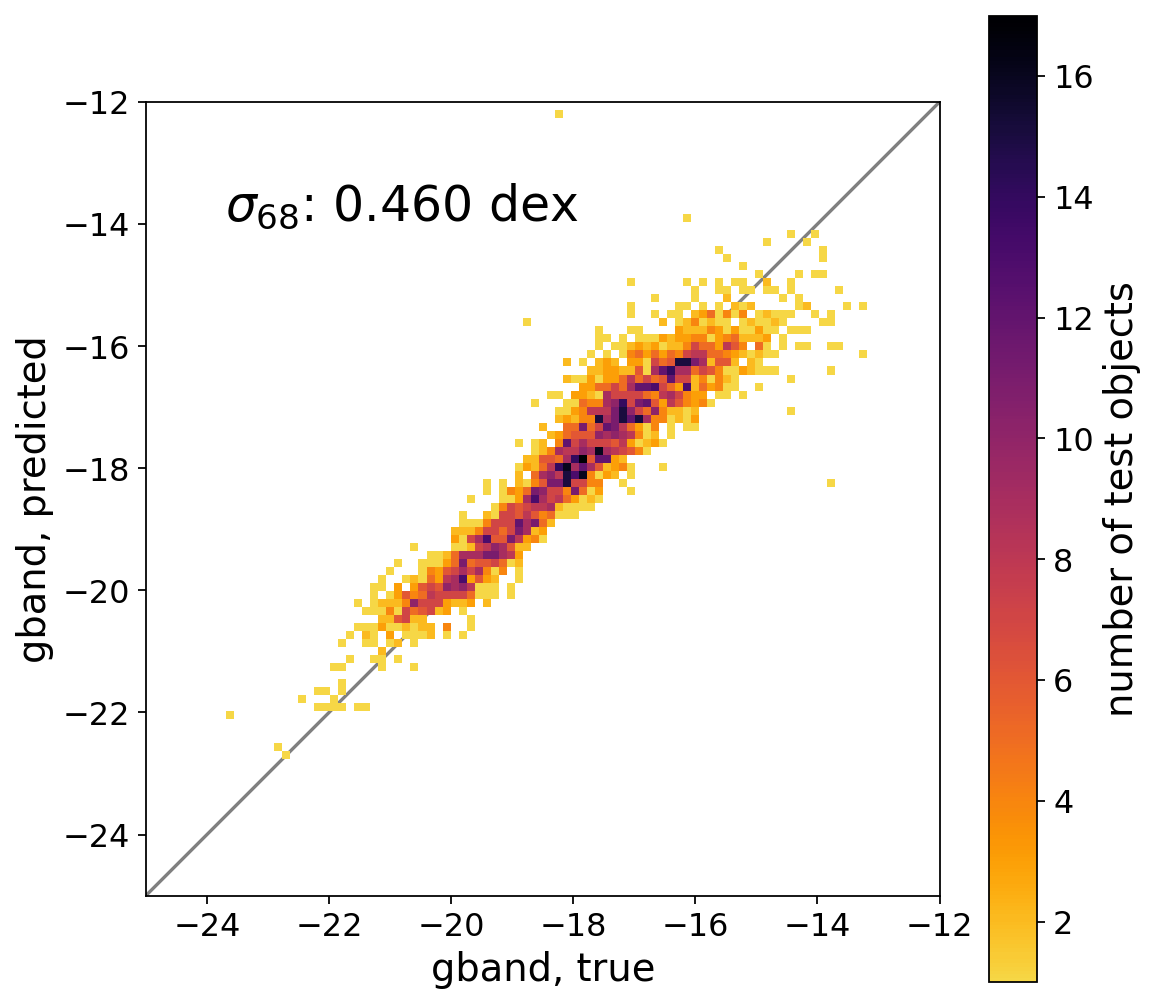

In [61]:
error_nn, _ = utils.compute_error(y_test, y_pred, test_error_type='percentile')
error_str = fr"$\sigma_{{68}}$: {error_nn:.3f} dex"
plotter.plot_pred_vs_true_hist(y_label_name, y_test, y_pred, text_results=error_str,
                               x_lim=(-25, -12),  y_lim=(-25, -12))

# g-i

In [62]:
y_label_name = 'gband_minus_iband'

In [66]:
fit_tag = f'_{y_label_name}_nn_scalars_epochs500_lr5e-05_hs128'
fn_model = f'../models/models_{sim_name}/model_{sim_name}{halo_tag}{geo_tag}{scalar_tag}{fit_tag}.pt'

In [67]:
y = utils.get_y_vals(y_label_name, sim_reader)
y_test = y[idx_test]

<KeysViewHDF5 ['Subhalo_StellarPhot_p07c_cf00dust_res_conv_ns1_rad30pkpc', 'subhaloIDs']>


In [68]:
nnfitter = NNFitter()
nnfitter.load_model(fn_model)

In [69]:
import torch
model_checkpoint = torch.load(fn_model)

444 8.09735850376663


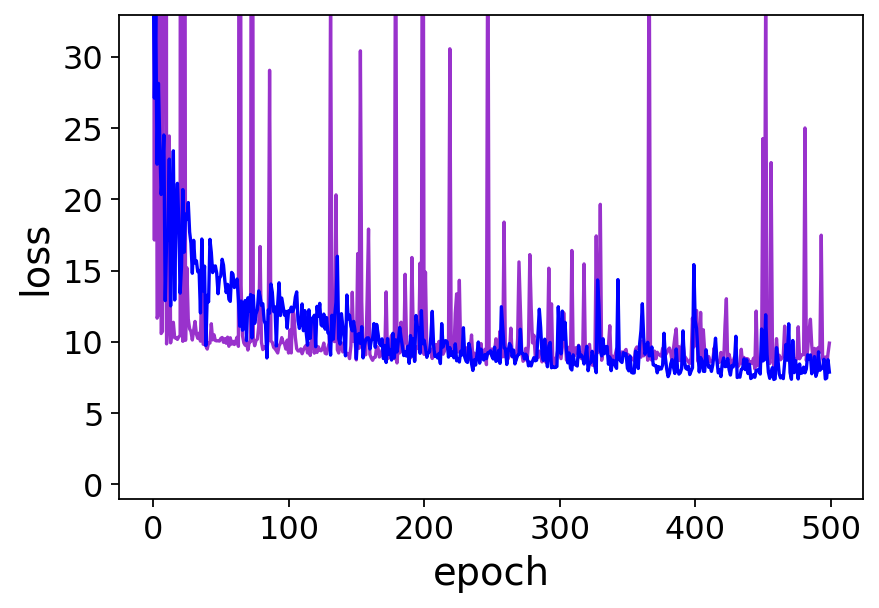

In [70]:
plt.plot(nnfitter.loss_valid, color='darkorchid', label='Validation')
plt.plot(nnfitter.loss_train, color='blue', label='Training')
plt.xlabel('epoch')
plt.ylabel('loss')
#plt.ylim(0,300)
plt.ylim(-1, nnfitter.loss_train[2])
print(np.argmin(nnfitter.loss_valid), np.min(nnfitter.loss_valid))

In [71]:
y_pred = nnfitter.predict(x_test, y_current=y_test_current, x_extra=x_test_extra)

/home/ksf293/equivariant-cosmology/notebooks/../code/utils.py:327: UserWarning: Trying to register the cmap 'shiftedcmap' which already exists.
  plt.register_cmap(cmap=newcmap)


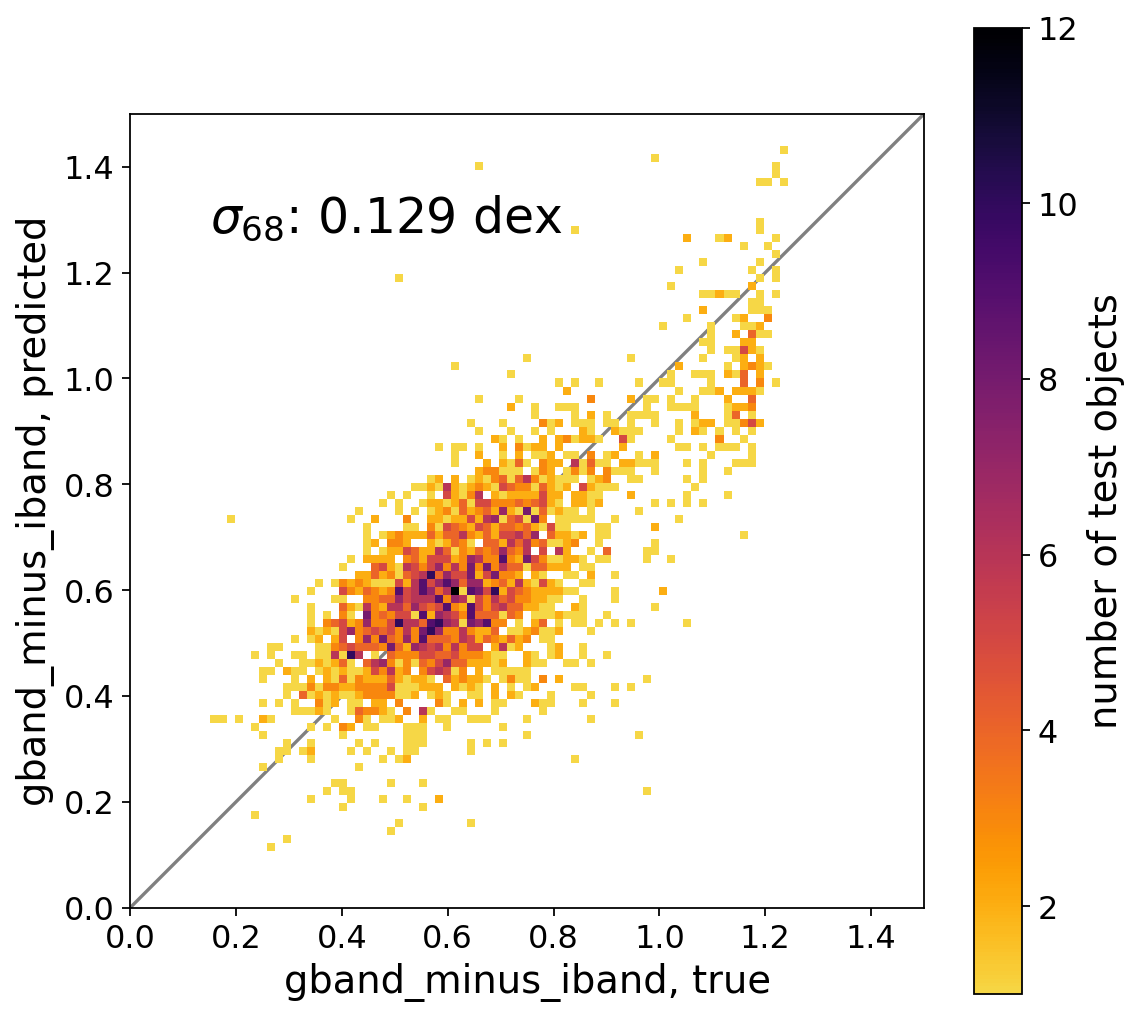

In [73]:
error_nn, _ = utils.compute_error(y_test, y_pred, test_error_type='percentile')
error_str = fr"$\sigma_{{68}}$: {error_nn:.3f} dex"
plotter.plot_pred_vs_true_hist(y_label_name, y_test, y_pred, text_results=error_str,
                               x_lim=(0, 1.5),  y_lim=(0, 1.5))

# Explore angular momentum

In [80]:
fn_stellar = f'{sim_reader.tng_path_hydro}/postprocessing/stellar_circs.hdf5'
f_stellar = h5py.File(fn_stellar)
stellar = f_stellar[f'Snapshot_{sim_reader.snap_num}']
print(stellar.keys())
print(stellar['SpecificAngMom'].shape)

<KeysViewHDF5 ['CircAbove07Frac', 'CircAbove07Frac_allstars', 'CircAbove07MinusBelowNeg07Frac', 'CircAbove07MinusBelowNeg07Frac_allstars', 'CircTwiceBelow0Frac', 'CircTwiceBelow0Frac_allstars', 'MassTensorEigenVals', 'ReducedMassTensorEigenVals', 'SpecificAngMom', 'SpecificAngMom_allstars', 'SubfindID']>
(32910,)


In [81]:
j_stellar = stellar['SpecificAngMom']

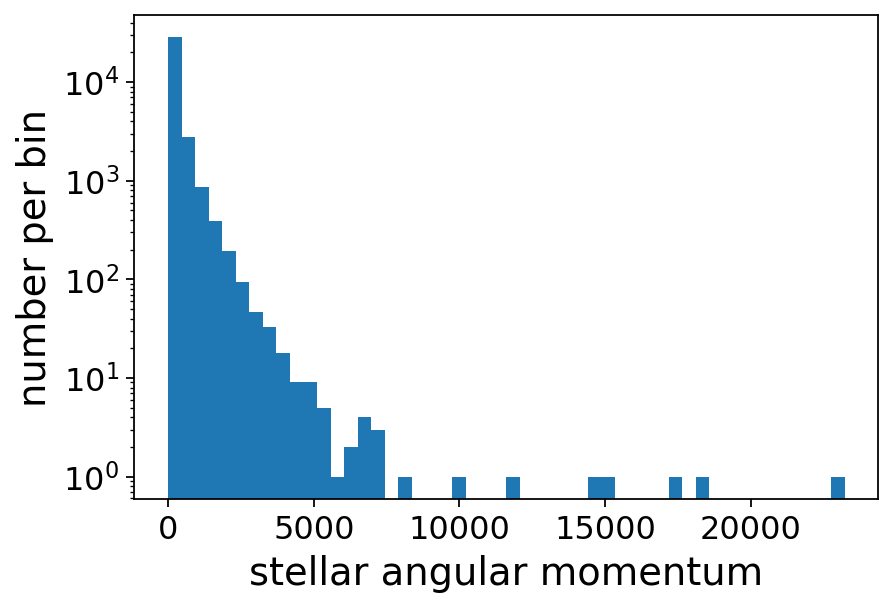

In [87]:
plt.hist(j_stellar, bins=50)
plt.xlabel('stellar angular momentum')
plt.ylabel('number per bin')
#plt.xscale('log')
plt.yscale('log')

### Shy's updated version with calculated values for all with >50 stellar particles

In [29]:
fn_stellar = f'{sim_reader.tng_path_hydro}/postprocessing/circularities_aligned_allstars_L75n1820TNG099.hdf5'
f_stellar = h5py.File(fn_stellar)
print(f_stellar.keys())
print(len(f_stellar['SpecificAngMom']))
# stellar = f_stellar[f'Snapshot_{sim_reader.snap_num}']
# print(stellar.keys())
# print(stellar['SpecificAngMom'].shape)

<KeysViewHDF5 ['CircAbove07Frac', 'CircAbove07MinusBelowNeg07Frac', 'CircTwiceBelow0Frac', 'SpecificAngMom', 'done']>
4371211


In [36]:
done = np.array(f_stellar['done']).flatten()
print(done.shape)

(4371211,)


In [37]:
i_done = done==1
print(np.sum(i_done))

67003


In [41]:
idxs_subhalo_hydro = np.array([halo.idx_subhalo_hydro for halo in sim_reader.dark_halo_arr])

In [76]:
j_stellar_all = np.array(f_stellar['SpecificAngMom']).flatten()
j_stellar_mine = j_stellar_all[idxs_subhalo_hydro] 

In [93]:
len(j_stellar_mine)

19670

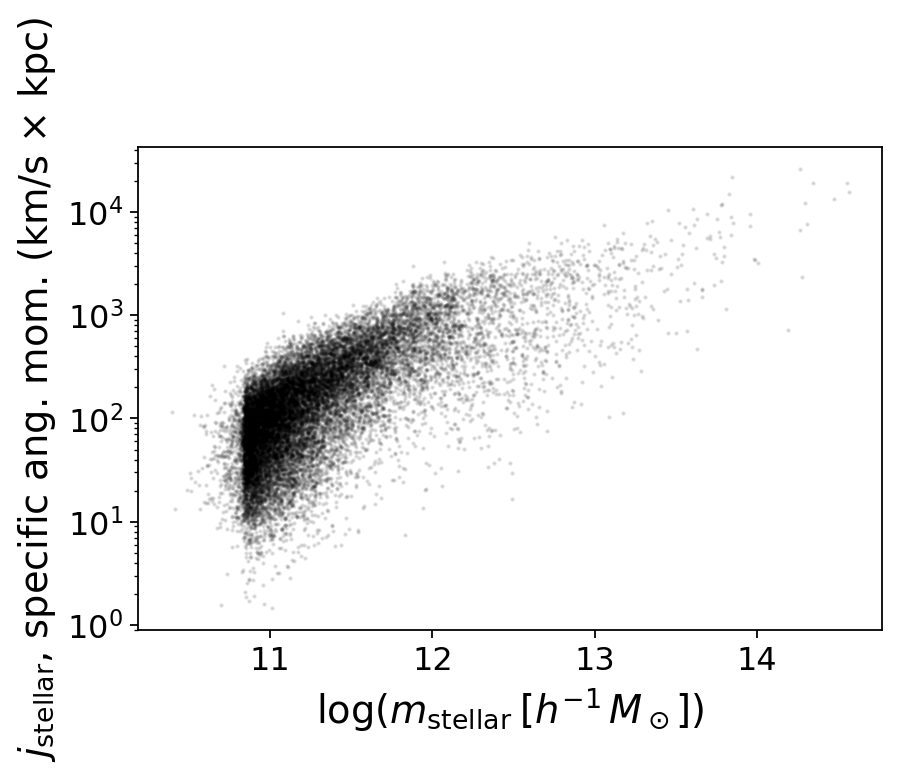

In [77]:
plt.scatter(log_m_200m+log_mass_shift, j_stellar_mine, color='k', s=1, alpha=0.1)
plt.ylabel(r'$j_\mathrm{stellar}$, specific ang. mom. (km/s $\times$ kpc)')
plt.xlabel(utils.label_dict['m_stellar'])
plt.yscale('log')

Text(0, 0.5, 'number per bin')

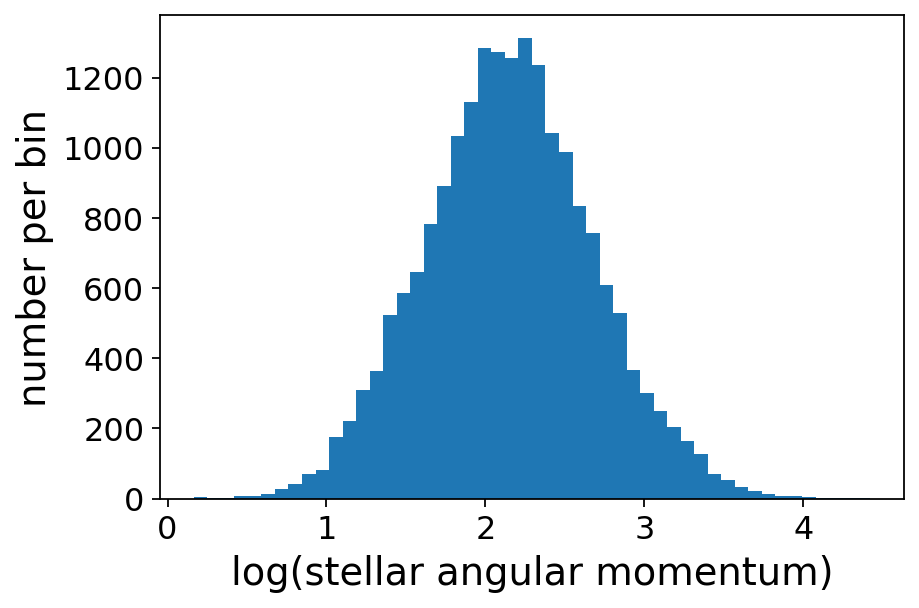

In [94]:
plt.hist(np.log10(j_stellar_mine), bins=50)
plt.xlabel('log(stellar angular momentum)')
plt.ylabel('number per bin')
#plt.xscale('log')
#plt.yscale('log')

### Now let's see results

In [79]:
y_label_name = 'j_stellar'

In [80]:
fit_tag = f'_{y_label_name}_nn_scalars_epochs500_lr5e-05_hs128'
fn_model = f'../models/models_{sim_name}/model_{sim_name}{halo_tag}{geo_tag}{scalar_tag}{fit_tag}.pt'

In [85]:
y = utils.get_y_vals(y_label_name, sim_reader)
y_test = y[idx_test]

In [101]:
len(y), np.min(y), np.max(y)

(19670, 0.16505784589805103, 4.421050098628936)

Text(0, 0.5, 'number per bin')

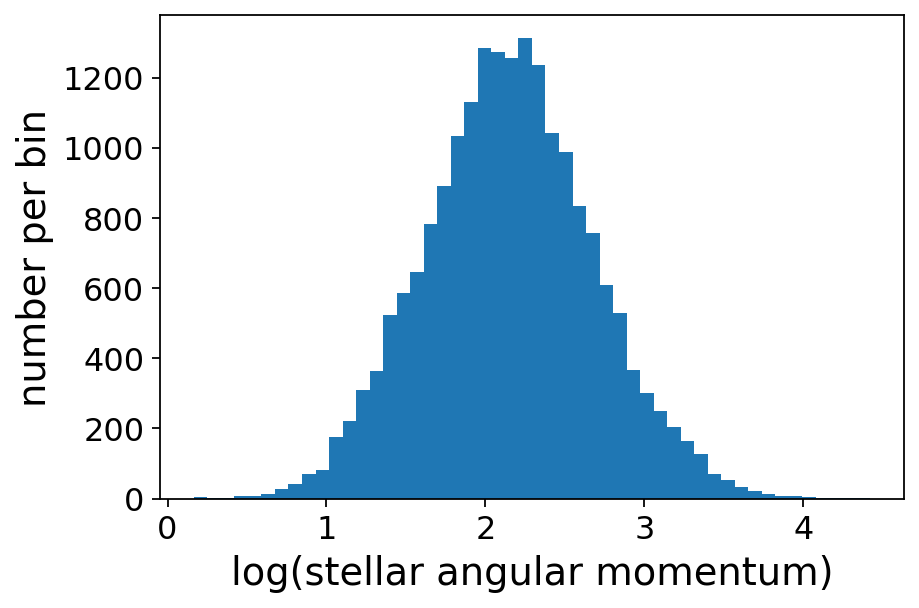

In [95]:
plt.hist(y, bins=50)
plt.xlabel('log(stellar angular momentum)')
plt.ylabel('number per bin')

In [96]:
nnfitter = NNFitter()
nnfitter.load_model(fn_model)

452 6.912498391022743


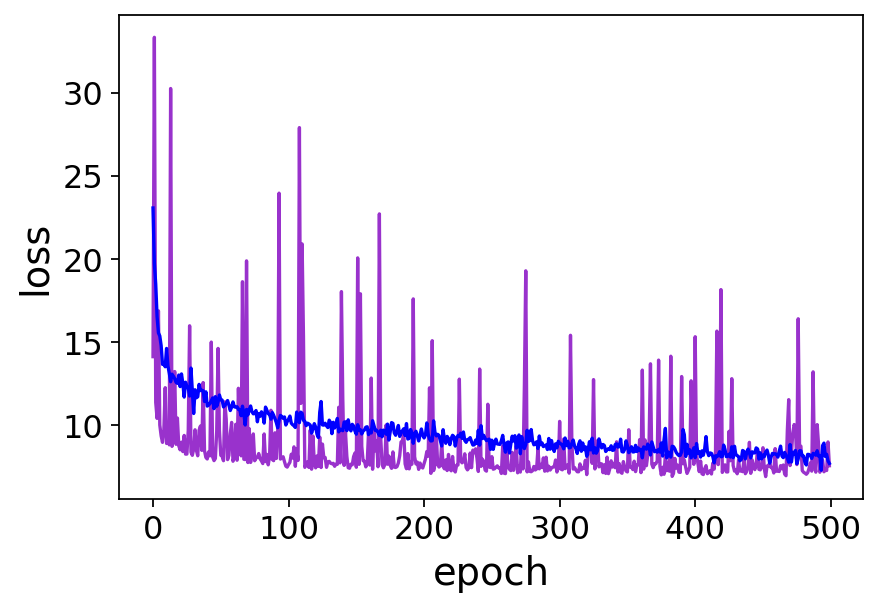

In [97]:
plt.plot(nnfitter.loss_valid, color='darkorchid', label='Validation')
plt.plot(nnfitter.loss_train, color='blue', label='Training')
plt.xlabel('epoch')
plt.ylabel('loss')
#plt.ylim(0,300)
#plt.ylim(-1, nnfitter.loss_train[2])
print(np.argmin(nnfitter.loss_valid), np.min(nnfitter.loss_valid))

In [98]:
y_pred = nnfitter.predict(x_test, y_current=y_test_current, x_extra=x_test_extra)

In [99]:
print(np.min(y_pred), np.max(y_pred))

0.7681776346548299 3.6025674901338296


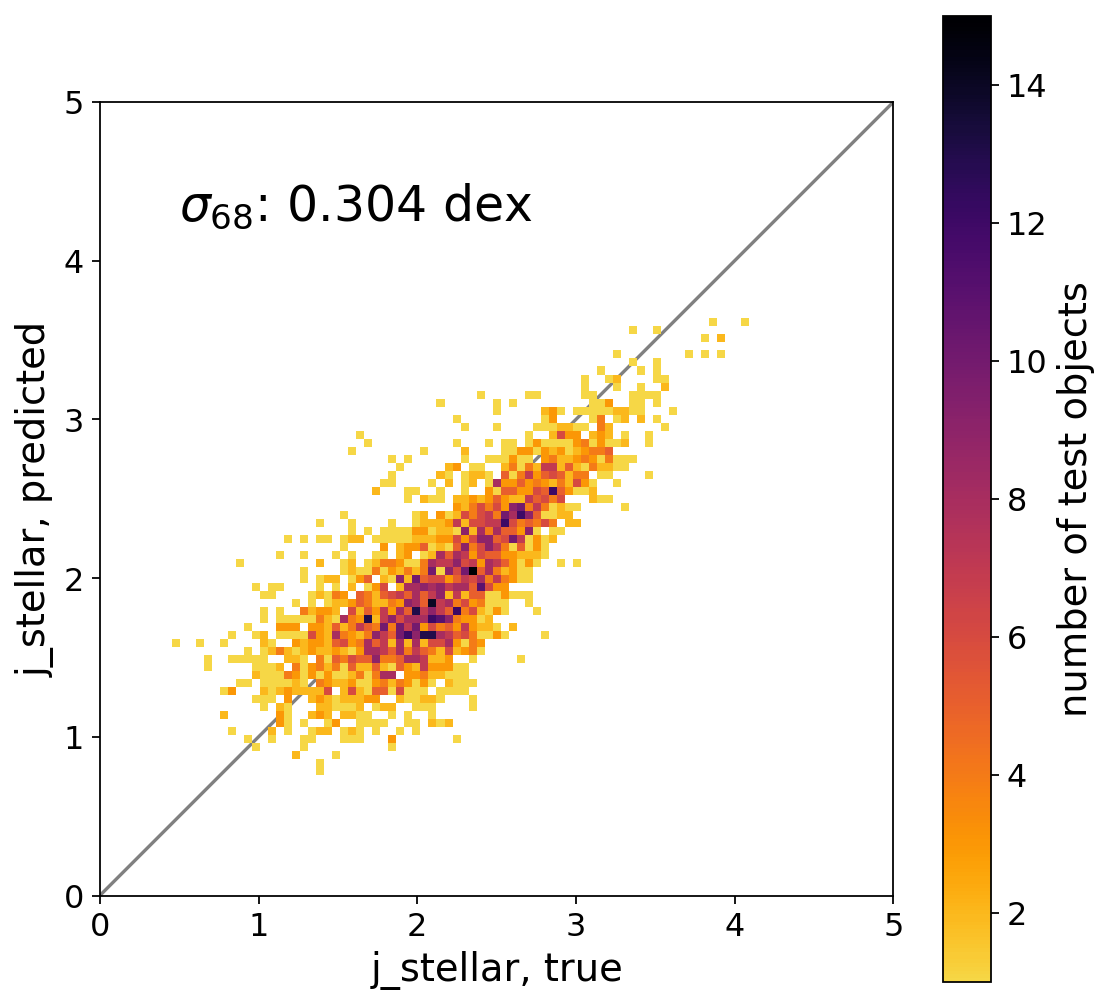

In [100]:
y_test_mult = y_test 
y_pred_mult = y_pred
error_nn, _ = utils.compute_error(y_test_mult, y_pred_mult, test_error_type='percentile')
error_str = fr"$\sigma_{{68}}$: {error_nn:.3f} dex"
plotter.plot_pred_vs_true_hist(y_label_name, y_test_mult, y_pred_mult, text_results=error_str,
                               x_lim=(0,5),  y_lim=(0,5))

# Black hole mass

In [15]:
sim_reader.add_catalog_property_to_halos('bhmass')
bhmass = np.array([halo.catalog_properties['bhmass'] for halo in sim_reader.dark_halo_arr])

In [16]:
print(np.min(bhmass), np.max(bhmass))

0.0 0.8383246


In [17]:
idx_nonzero = bhmass != 0.0
print(np.sum(idx_nonzero)/len(idx_nonzero))

0.9892221657346213


In [18]:
print(np.min(bhmass[idx_nonzero]))

8e-05


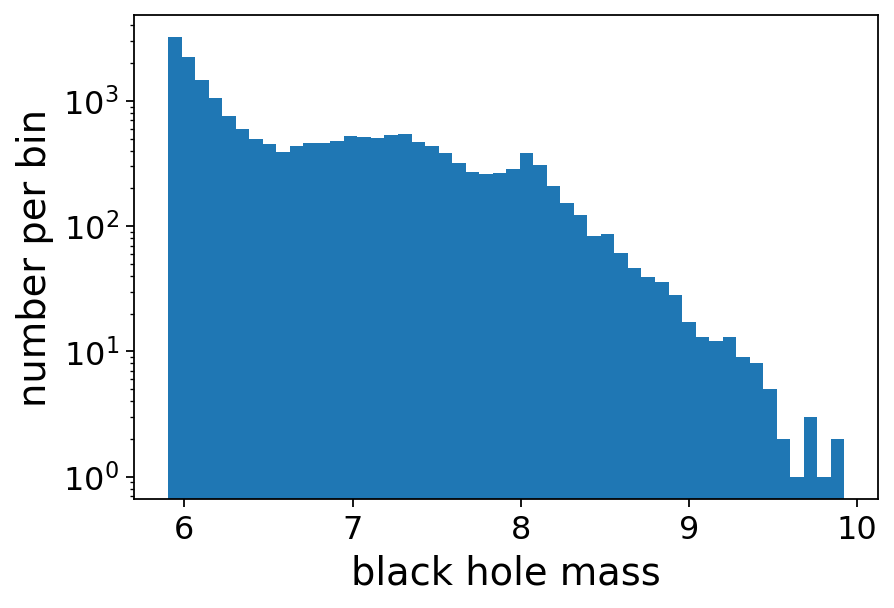

In [108]:
plt.hist(np.log10(bhmass[idx_nonzero])+log_mass_shift, bins=50)
plt.xlabel('black hole mass')
plt.ylabel('number per bin')
plt.yscale('log')

In [22]:
bhm = utils.get_y_vals('bhmass', sim_reader)

Text(0, 0.5, 'bhmass')

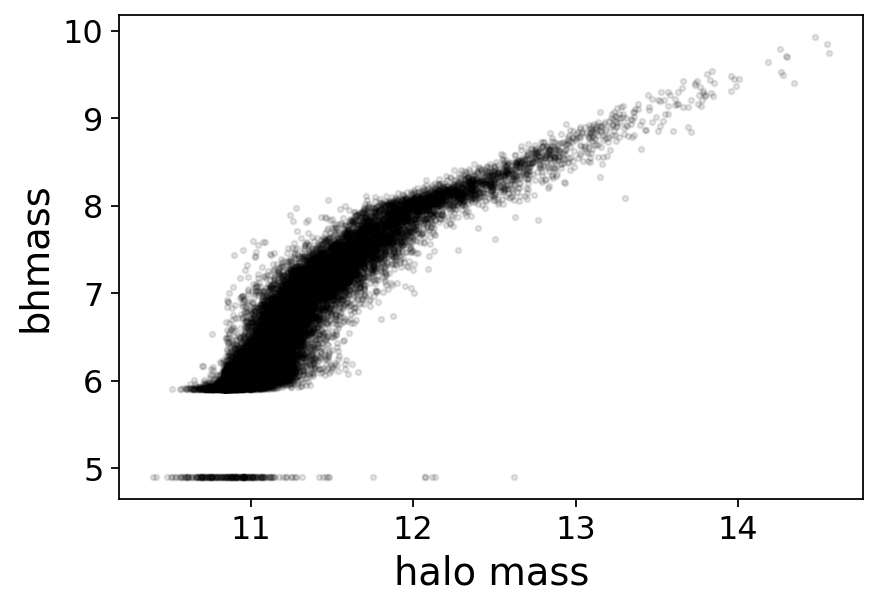

In [48]:

#plt.hist2d(np.log10(m_200m)+log_mass_shift, np.log10(bhmass[idx_nonzero])+log_mass_shift)
plt.scatter(np.log10(m_200m)+log_mass_shift, bhm+log_mass_shift, alpha=0.1, color='k', s=6)

plt.xlabel('halo mass')
plt.ylabel('bhmass')
#plt.yscale('log')

In [17]:
y_label_name = 'bhmass'

In [18]:
fit_tag = f'_{y_label_name}_nn_scalars_epochs500_lr5e-05_hs128'
fn_model = f'../models/models_{sim_name}/model_{sim_name}{halo_tag}{geo_tag}{scalar_tag}{fit_tag}.pt'

In [19]:
y = utils.get_y_vals(y_label_name, sim_reader)
y_test = y[idx_test]

In [20]:
nnfitter = NNFitter()
nnfitter.load_model(fn_model)

In [21]:
import torch
model_checkpoint = torch.load(fn_model)

182 -0.7844955391375599


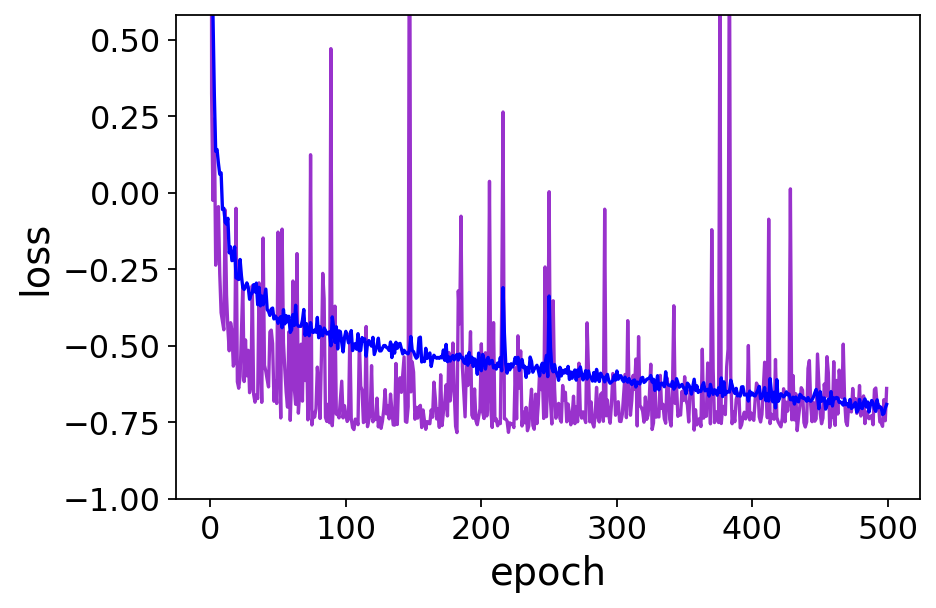

In [22]:
plt.plot(nnfitter.loss_valid, color='darkorchid', label='Validation')
plt.plot(nnfitter.loss_train, color='blue', label='Training')
plt.xlabel('epoch')
plt.ylabel('loss')
#plt.ylim(0,300)
plt.ylim(-1, nnfitter.loss_train[2])
print(np.argmin(nnfitter.loss_valid), np.min(nnfitter.loss_valid))

In [23]:
y_pred = nnfitter.predict(x_test, y_current=y_test_current, x_extra=x_test_extra)

/home/ksf293/equivariant-cosmology/notebooks/../code/utils.py:332: UserWarning: Trying to register the cmap 'shiftedcmap' which already exists.
  plt.register_cmap(cmap=newcmap)


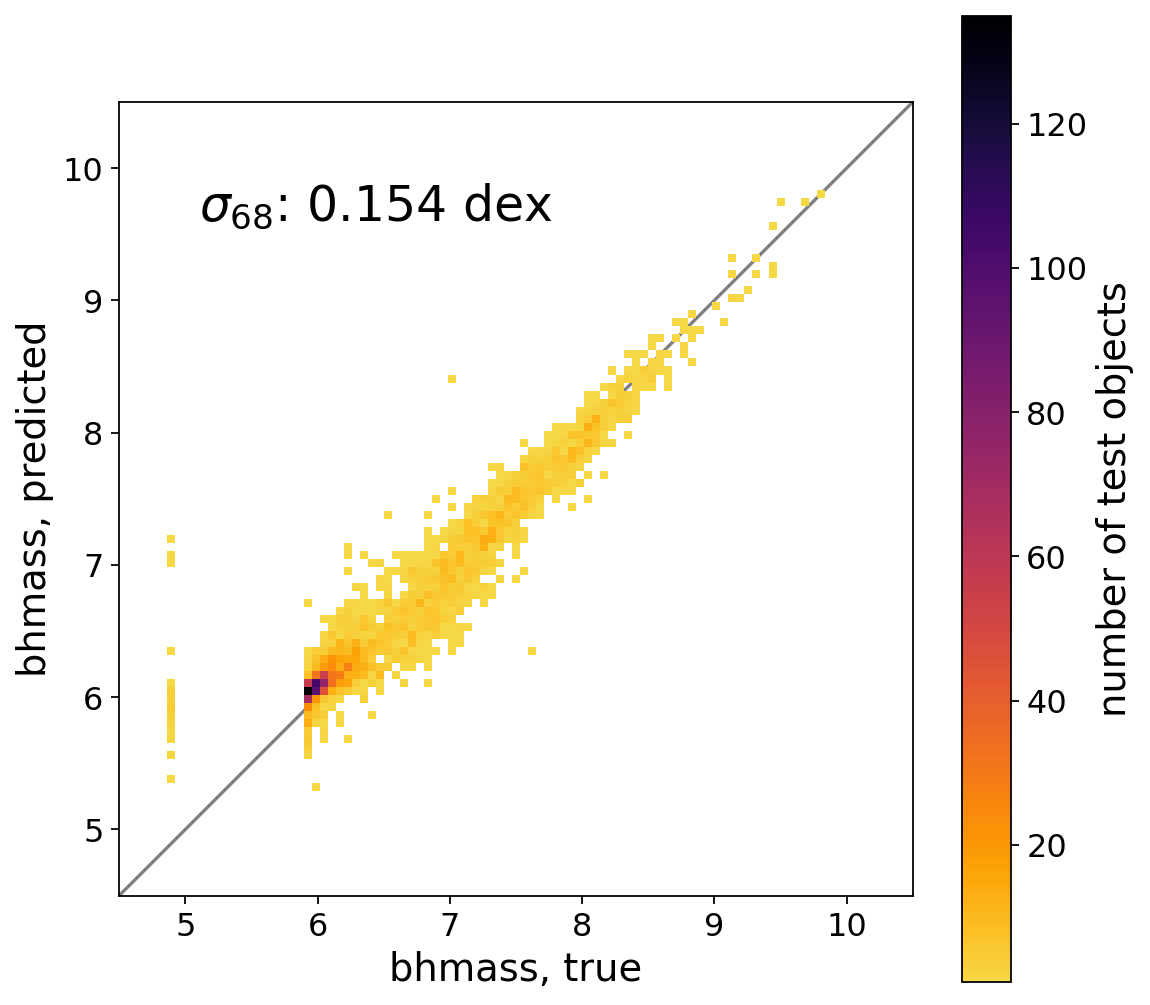

In [25]:
y_test_mult = y_test + log_mass_shift
y_pred_mult = y_pred + log_mass_shift
error_nn, _ = utils.compute_error(y_test_mult, y_pred_mult, test_error_type='percentile')
error_str = fr"$\sigma_{{68}}$: {error_nn:.3f} dex"
plotter.plot_pred_vs_true_hist(y_label_name, y_test_mult, y_pred_mult, text_results=error_str,
                               x_lim=(4.5,10.5),  y_lim=(4.5,10.5))

# BHmass per m_stellar

In [19]:
m_stellar = utils.get_y_vals('m_stellar', sim_reader)

Text(0, 0.5, 'bhmass')

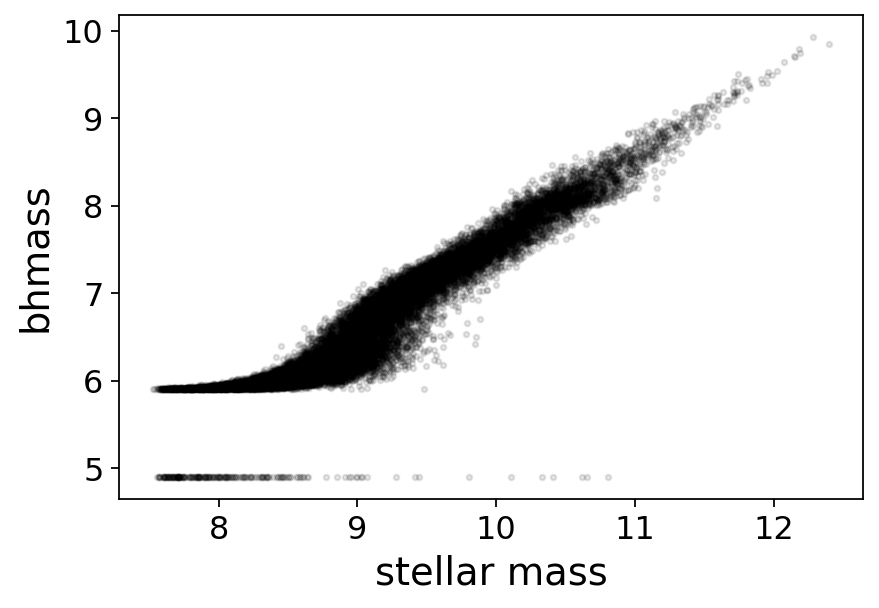

In [51]:
#plt.hist2d(np.log10(m_200m)+log_mass_shift, np.log10(bhmass[idx_nonzero])+log_mass_shift)
plt.scatter(m_stellar+log_mass_shift, bhm+log_mass_shift, alpha=0.1, color='k', s=6)

plt.xlabel('stellar mass')
plt.ylabel('bhmass')
#plt.yscale('log')

Text(0, 0.5, '$M_\\mathrm{BH}/m_\\mathrm{*}$')

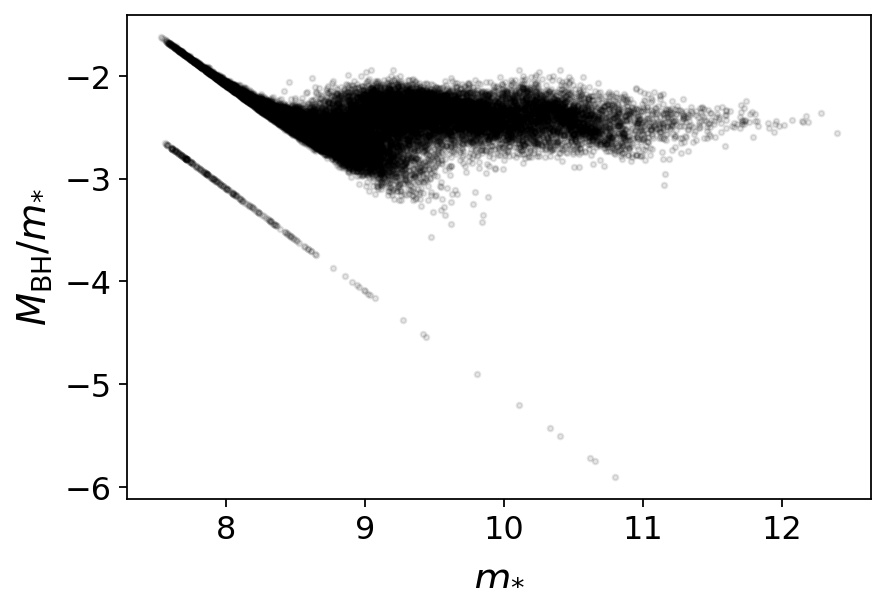

In [57]:
#plt.hist2d(np.log10(m_200m)+log_mass_shift, np.log10(bhmass[idx_nonzero])+log_mass_shift)
bhm_per_mstellar = bhm-m_stellar
plt.scatter(m_stellar+log_mass_shift, bhm_per_mstellar, alpha=0.1, color='k', s=6)

plt.xlabel(r'$m_\mathrm{*}$')
plt.ylabel(r'$M_\mathrm{BH}/m_\mathrm{*}$')
#plt.yscale('log')

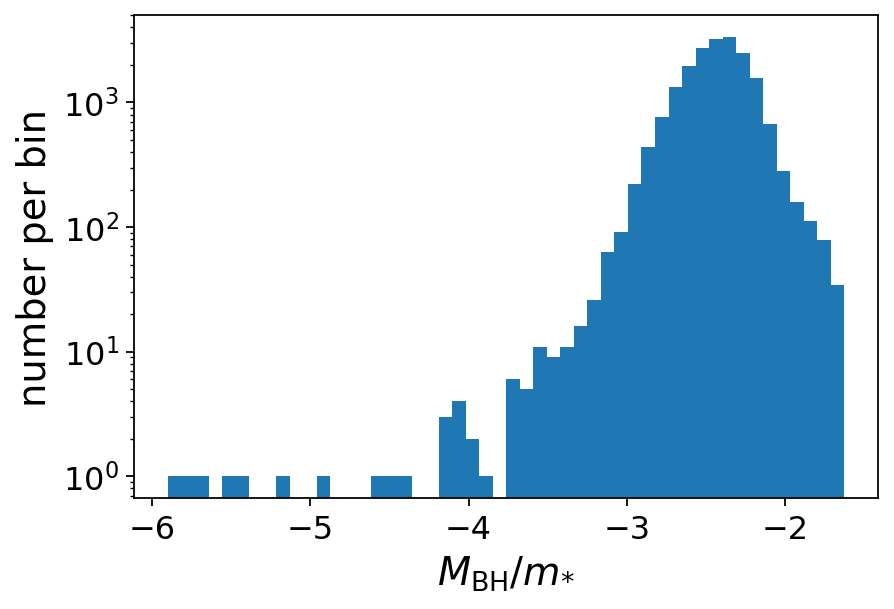

In [58]:
#plt.hist(np.log10(bhmass[idx_nonzero])+log_mass_shift, bins=50)
plt.hist(bhm_per_mstellar, bins=50)

plt.xlabel(r'$M_\mathrm{BH}/m_\mathrm{*}$')
plt.ylabel('number per bin')
plt.yscale('log')

In [68]:
bhmass_per_mstellar = utils.get_y_vals('bhmass_per_mstellar', sim_reader)

In [69]:
np.min(bhmass_per_mstellar), np.max(bhmass_per_mstellar)

(-4.092072486877441, -1.6238923072814941)

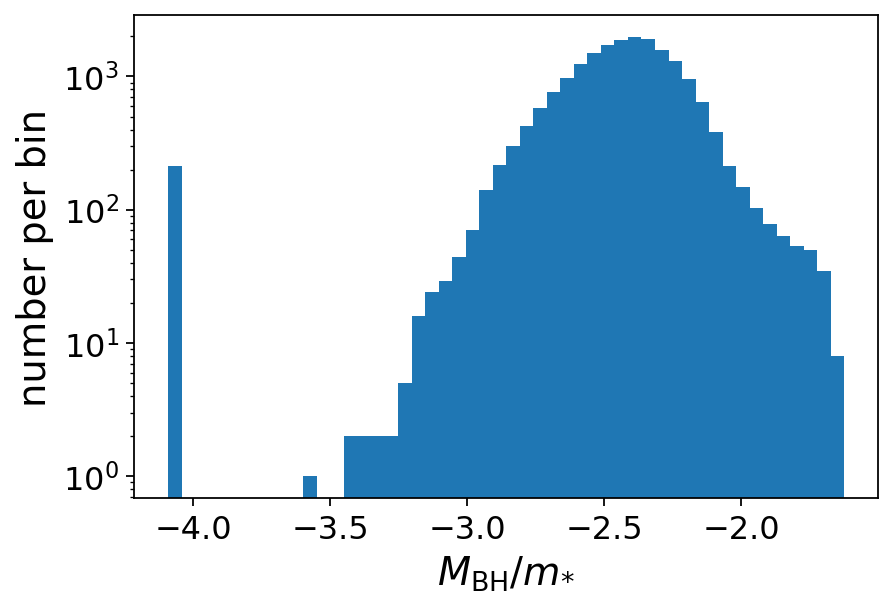

In [71]:
#plt.hist(np.log10(bhmass[idx_nonzero])+log_mass_shift, bins=50)
plt.hist(bhmass_per_mstellar, bins=50)

plt.xlabel(r'$M_\mathrm{BH}/m_\mathrm{*}$')
plt.ylabel('number per bin')
plt.yscale('log')

Text(0, 0.5, '$M_\\mathrm{BH}/m_\\mathrm{*}$')

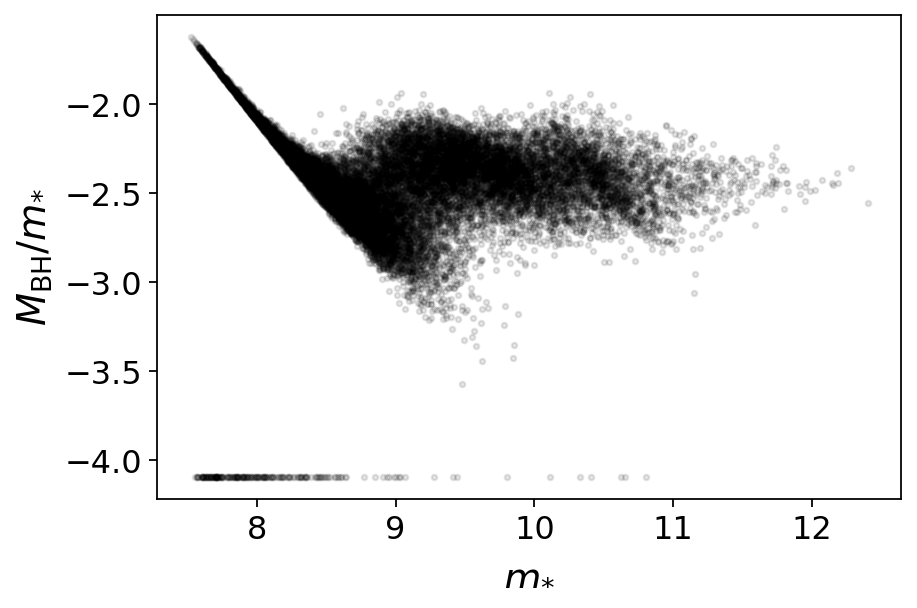

In [72]:
plt.scatter(m_stellar+log_mass_shift, bhmass_per_mstellar, alpha=0.1, color='k', s=6)

plt.xlabel(r'$m_\mathrm{*}$')
plt.ylabel(r'$M_\mathrm{BH}/m_\mathrm{*}$')
#plt.yscale('log')

In [19]:
y_label_name = 'bhmass_per_mstellar'

In [20]:
fit_tag = f'_{y_label_name}_nn_scalars_epochs500_lr5e-05_hs128'
fn_model = f'../models/models_{sim_name}/model_{sim_name}{halo_tag}{geo_tag}{scalar_tag}{fit_tag}.pt'

In [21]:
y = utils.get_y_vals(y_label_name, sim_reader)
y_test = y[idx_test]

In [22]:
nnfitter = NNFitter()
nnfitter.load_model(fn_model)

In [23]:
import torch
model_checkpoint = torch.load(fn_model)

148 -0.4656023042704825


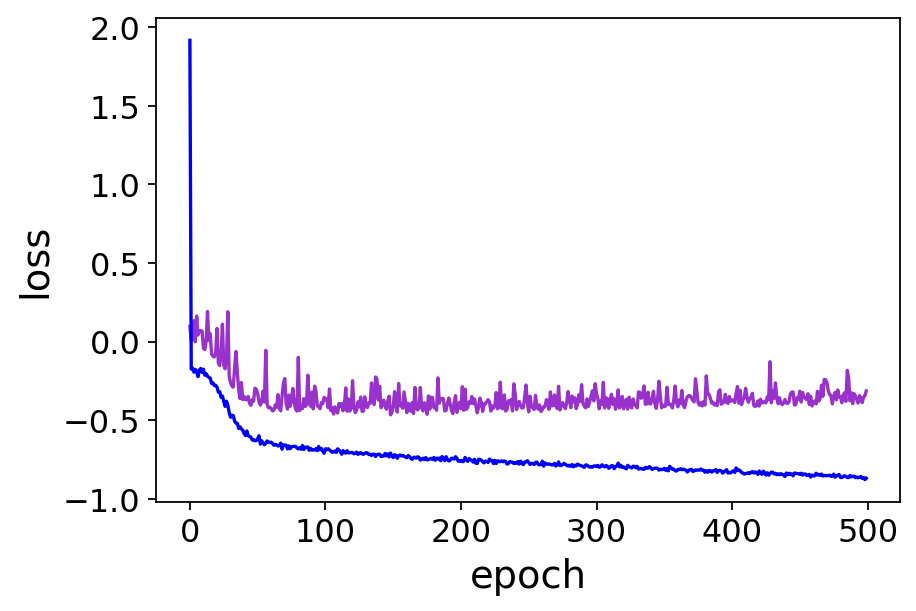

In [24]:
plt.plot(nnfitter.loss_valid, color='darkorchid', label='Validation')
plt.plot(nnfitter.loss_train, color='blue', label='Training')
plt.xlabel('epoch')
plt.ylabel('loss')
#plt.ylim(0,300)
#plt.ylim(-1, nnfitter.loss_train[2])
print(np.argmin(nnfitter.loss_valid), np.min(nnfitter.loss_valid))

In [25]:
y_pred = nnfitter.predict(x_test, y_current=y_test_current, x_extra=x_test_extra)

In [26]:
np.min(y_pred), np.max(y_pred)

(-3.8383553844653084, -0.5221230599304538)

/home/ksf293/equivariant-cosmology/notebooks/../code/utils.py:337: UserWarning: Trying to register the cmap 'shiftedcmap' which already exists.
  plt.register_cmap(cmap=newcmap)


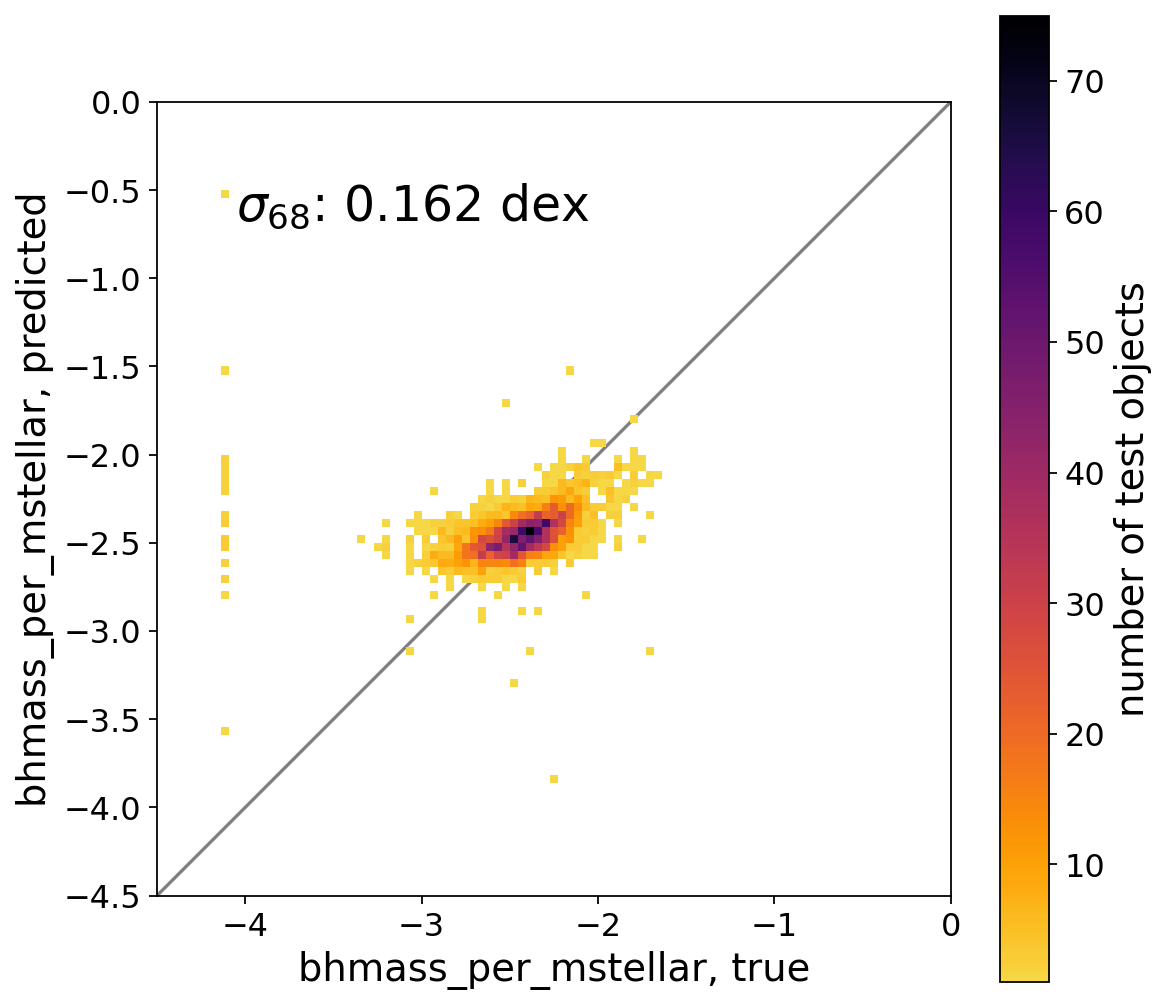

In [50]:
y_test_mult = y_test
y_pred_mult = y_pred
error_nn, _ = utils.compute_error(y_test_mult, y_pred_mult, test_error_type='percentile')
error_str = fr"$\sigma_{{68}}$: {error_nn:.3f} dex"
plotter.plot_pred_vs_true_hist(y_label_name, y_test_mult, y_pred_mult, text_results=error_str,
                               x_lim=(-4.5,0),  y_lim=(-4.5,0))

In [35]:
x_label_name = 'm_stellar'
x_property = utils.get_y_vals(x_label_name, sim_reader)[idx_test]
x_property_mult = x_property + log_mass_shift

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


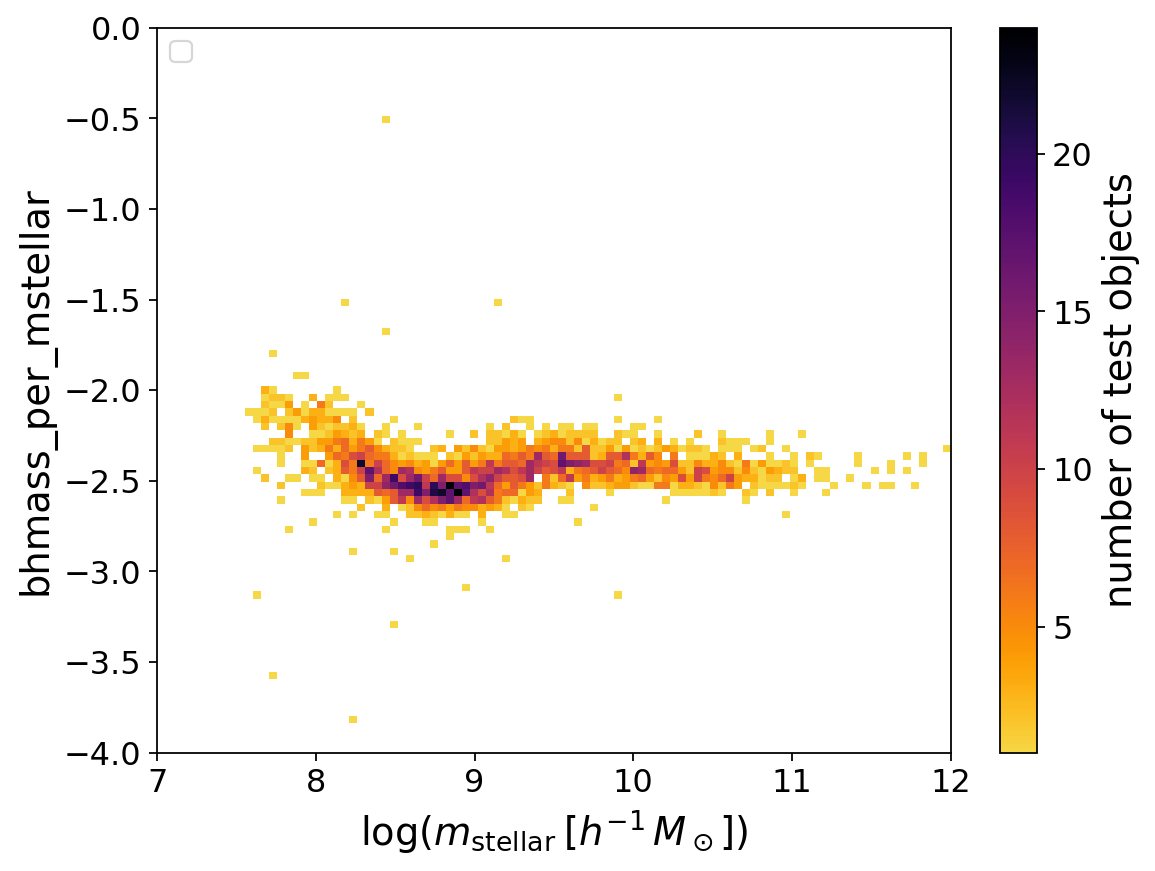

In [40]:
y_test_mult = y_test
y_pred_mult = y_pred
error_nn, _ = utils.compute_error(y_test_mult, y_pred_mult, test_error_type='percentile')
error_str = fr"$\sigma_{{68}}$: {error_nn:.3f} dex"
plotter.plot_pred_vs_property_hist(x_label_name, y_label_name, x_property_mult, y_pred_mult, 
                                   x_lim=(7,12),  y_lim=(-4,0))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


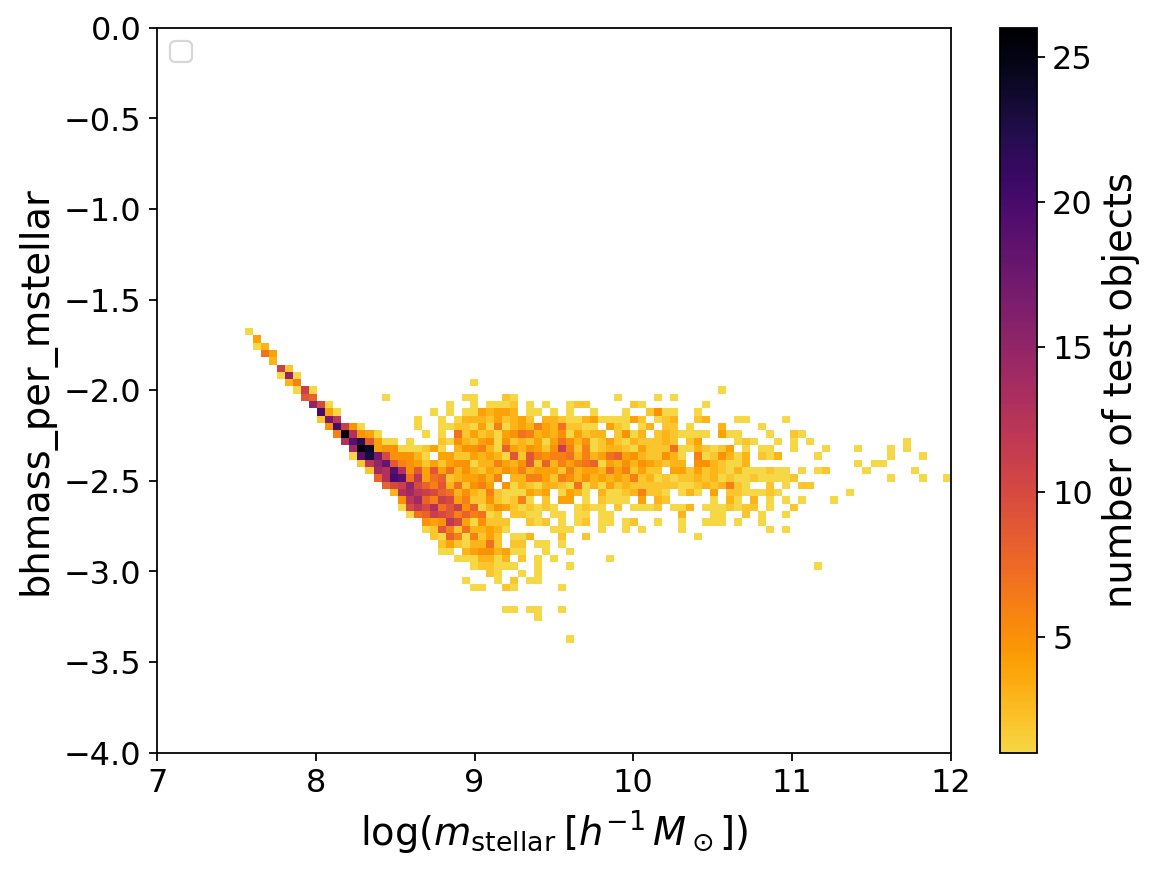

In [41]:
y_test_mult = y_test
y_pred_mult = y_pred
error_nn, _ = utils.compute_error(y_test_mult, y_pred_mult, test_error_type='percentile')
error_str = fr"$\sigma_{{68}}$: {error_nn:.3f} dex"
plotter.plot_pred_vs_property_hist(x_label_name, y_label_name, x_property_mult, y_test_mult, 
                                   x_lim=(7,12),  y_lim=(-4,0))

Text(0, 0.5, 'bhmass_per_mstellar (pred)')

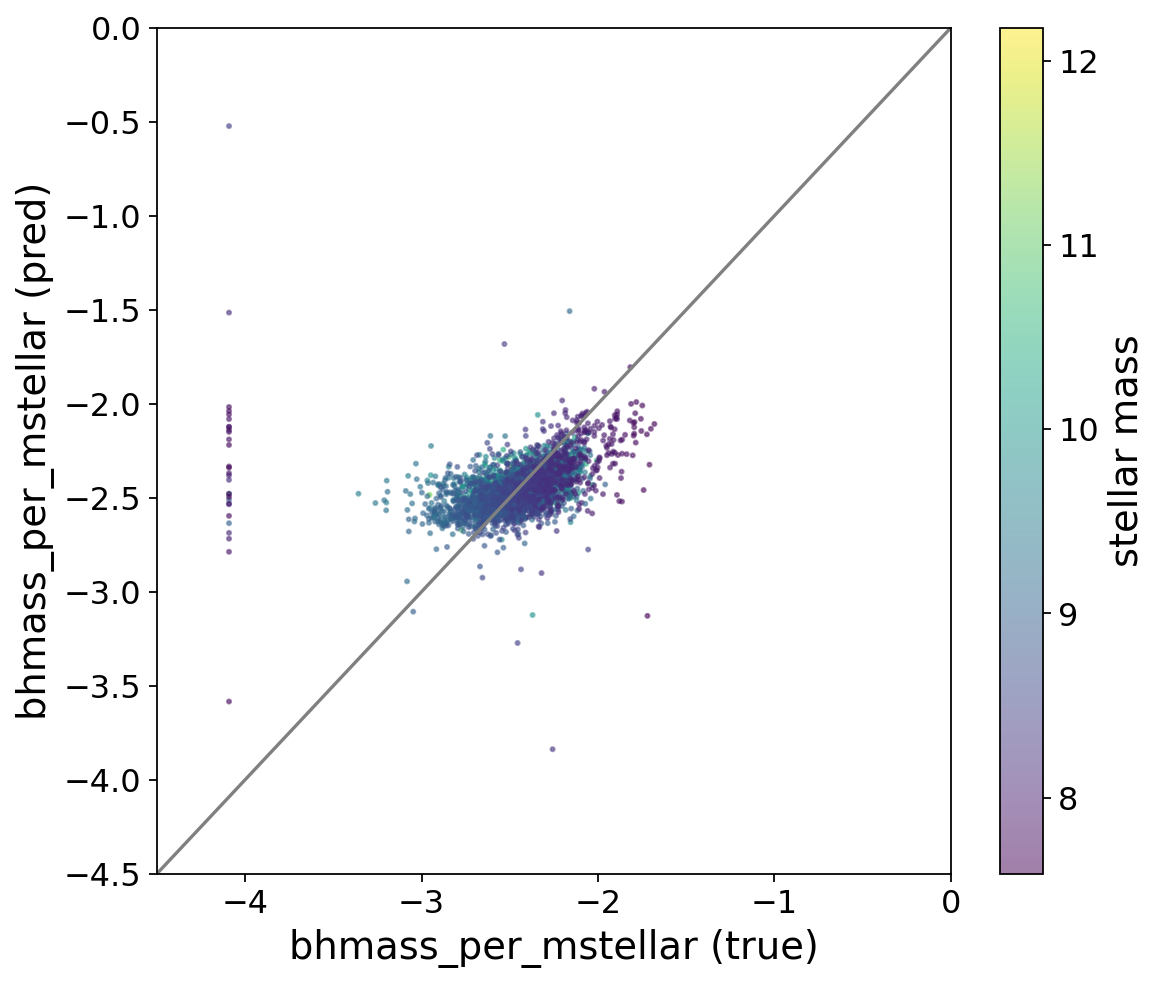

In [58]:
plt.figure(figsize=(8,7))

xx = np.linspace(-4.5,0)
plt.plot(xx, xx, color='grey')

plt.scatter(y_test_mult, y_pred_mult, c=x_property_mult, s=3, alpha=0.5)
plt.colorbar(label='stellar mass')

plt.xlim(-4.5, 0)
plt.ylim(-4.5, 0)

plt.xlabel(y_label_name+' (true)')
plt.ylabel(y_label_name+' (pred)')

# ratio last merger

In [18]:
y_label_name = 'ratio_last_major_merger'

In [19]:
fit_tag = f'_{y_label_name}_nn_scalars_epochs500_lr5e-05_hs128'
fn_model = f'../models/models_{sim_name}/model_{sim_name}{halo_tag}{geo_tag}{scalar_tag}{fit_tag}.pt'

In [20]:
y = utils.get_y_vals(y_label_name, sim_reader)
y_test = y[idx_test]

In [21]:
nnfitter = NNFitter()
nnfitter.load_model(fn_model)

In [22]:
import torch
model_checkpoint = torch.load(fn_model)

262 149.97007498009268


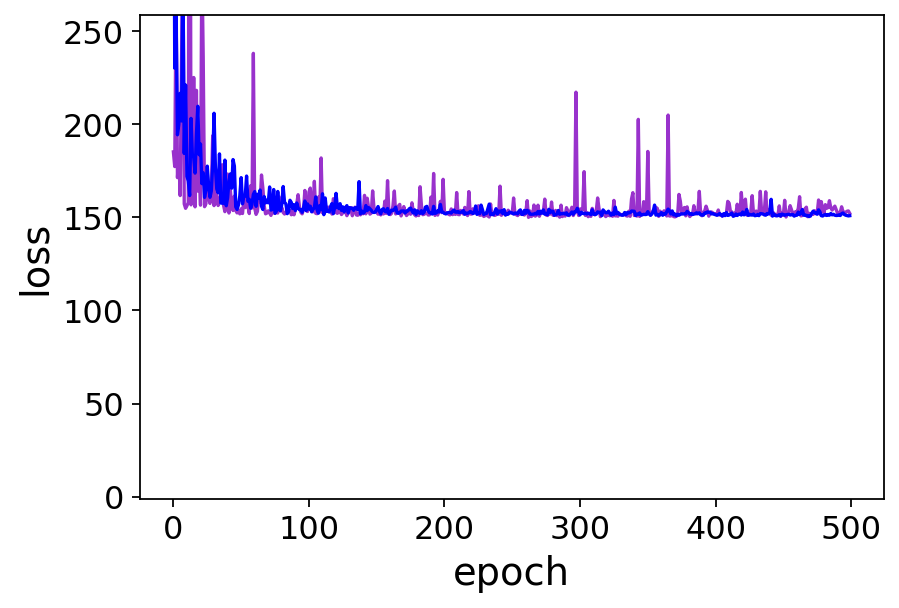

In [23]:
plt.plot(nnfitter.loss_valid, color='darkorchid', label='Validation')
plt.plot(nnfitter.loss_train, color='blue', label='Training')
plt.xlabel('epoch')
plt.ylabel('loss')
#plt.ylim(0,300)
plt.ylim(-1, nnfitter.loss_train[2])
print(np.argmin(nnfitter.loss_valid), np.min(nnfitter.loss_valid))

In [24]:
y_pred = nnfitter.predict(x_test, y_current=y_test_current, x_extra=x_test_extra)

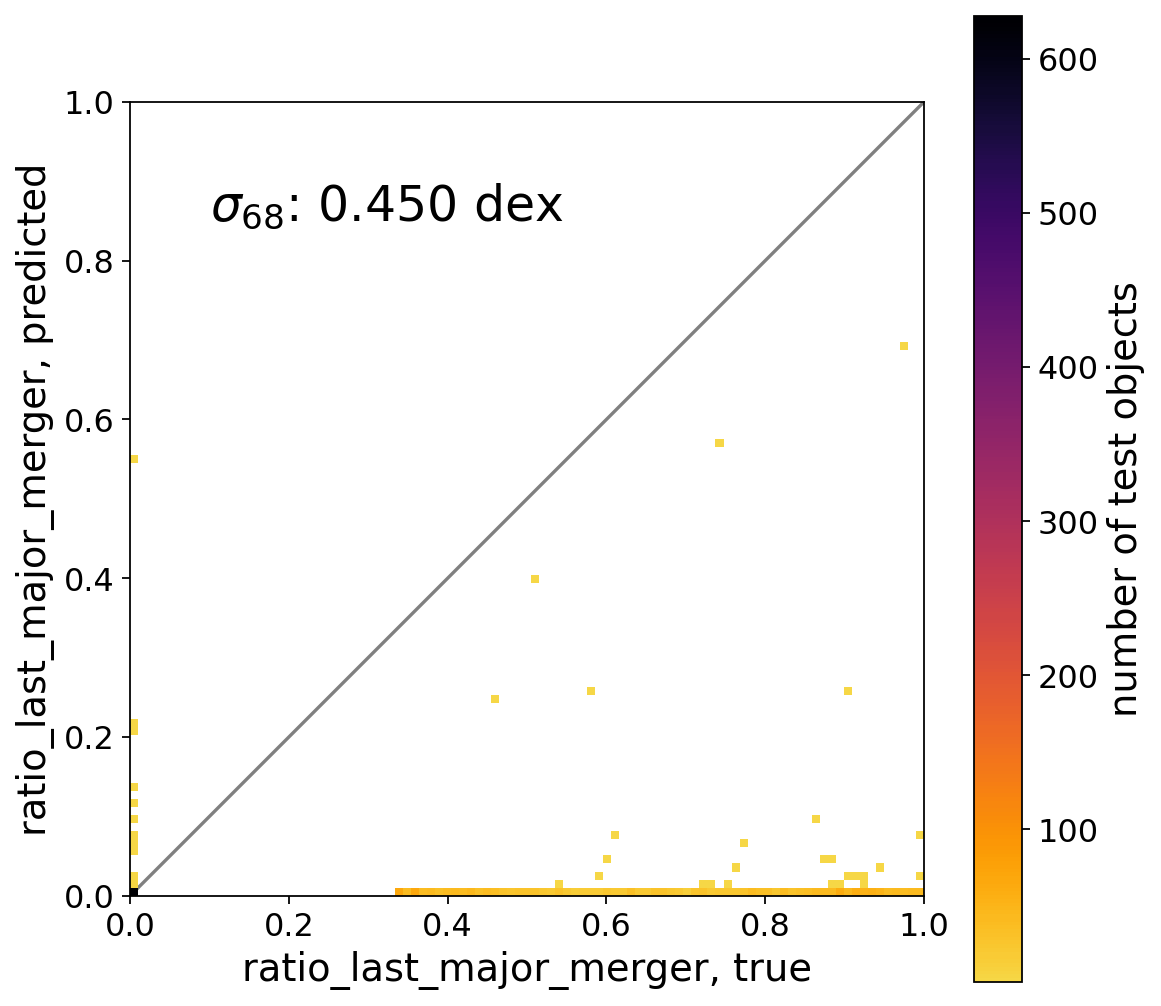

In [25]:
y_test_mult = y_test 
y_pred_mult = y_pred
error_nn, _ = utils.compute_error(y_test_mult, y_pred_mult, test_error_type='percentile')
error_str = fr"$\sigma_{{68}}$: {error_nn:.3f} dex"
plotter.plot_pred_vs_true_hist(y_label_name, y_test_mult, y_pred_mult, text_results=error_str,
                               x_lim=(0,1),  y_lim=(0,1))

# nm

In [36]:
y_label_name = 'num_mergers'

In [37]:
fit_tag = f'_{y_label_name}_nn_scalars_epochs500_lr5e-05_hs128'
fn_model = f'../models/models_{sim_name}/model_{sim_name}{halo_tag}{geo_tag}{scalar_tag}{fit_tag}.pt'

In [38]:
y = utils.get_y_vals(y_label_name, sim_reader)
y_test = y[idx_test]

In [39]:
nnfitter = NNFitter()
nnfitter.load_model(fn_model)

In [40]:
import torch
model_checkpoint = torch.load(fn_model)

238 -1.6114601374797592


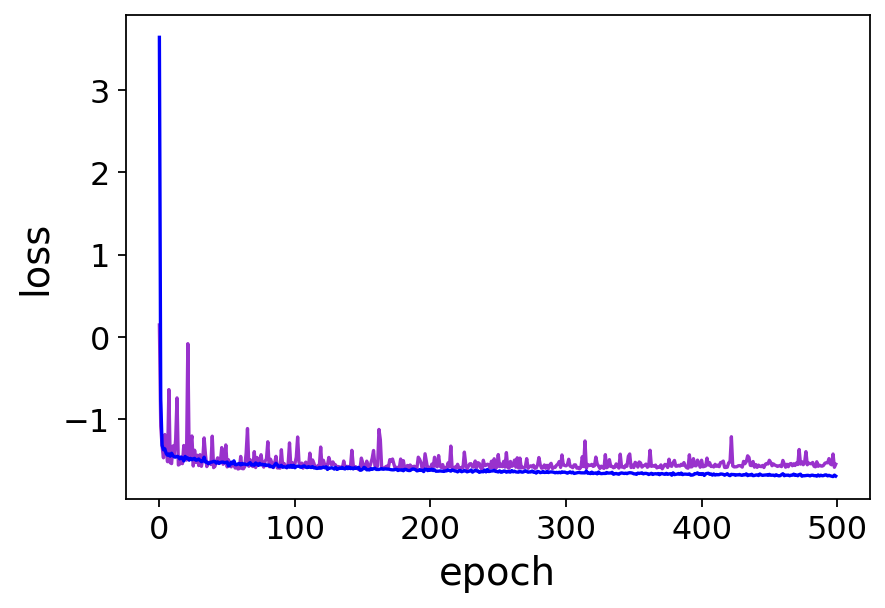

In [43]:
plt.plot(nnfitter.loss_valid, color='darkorchid', label='Validation')
plt.plot(nnfitter.loss_train, color='blue', label='Training')
plt.xlabel('epoch')
plt.ylabel('loss')
#plt.ylim(0,300)
#plt.ylim(-1, nnfitter.loss_train[2])
print(np.argmin(nnfitter.loss_valid), np.min(nnfitter.loss_valid))

In [44]:
y_pred = nnfitter.predict(x_test, y_current=y_test_current, x_extra=x_test_extra)

In [45]:
print(np.min(y_pred), np.max(y_pred))

0.18741529834049395 4.227572611019824


/home/ksf293/equivariant-cosmology/notebooks/../code/utils.py:337: UserWarning: Trying to register the cmap 'shiftedcmap' which already exists.
  plt.register_cmap(cmap=newcmap)


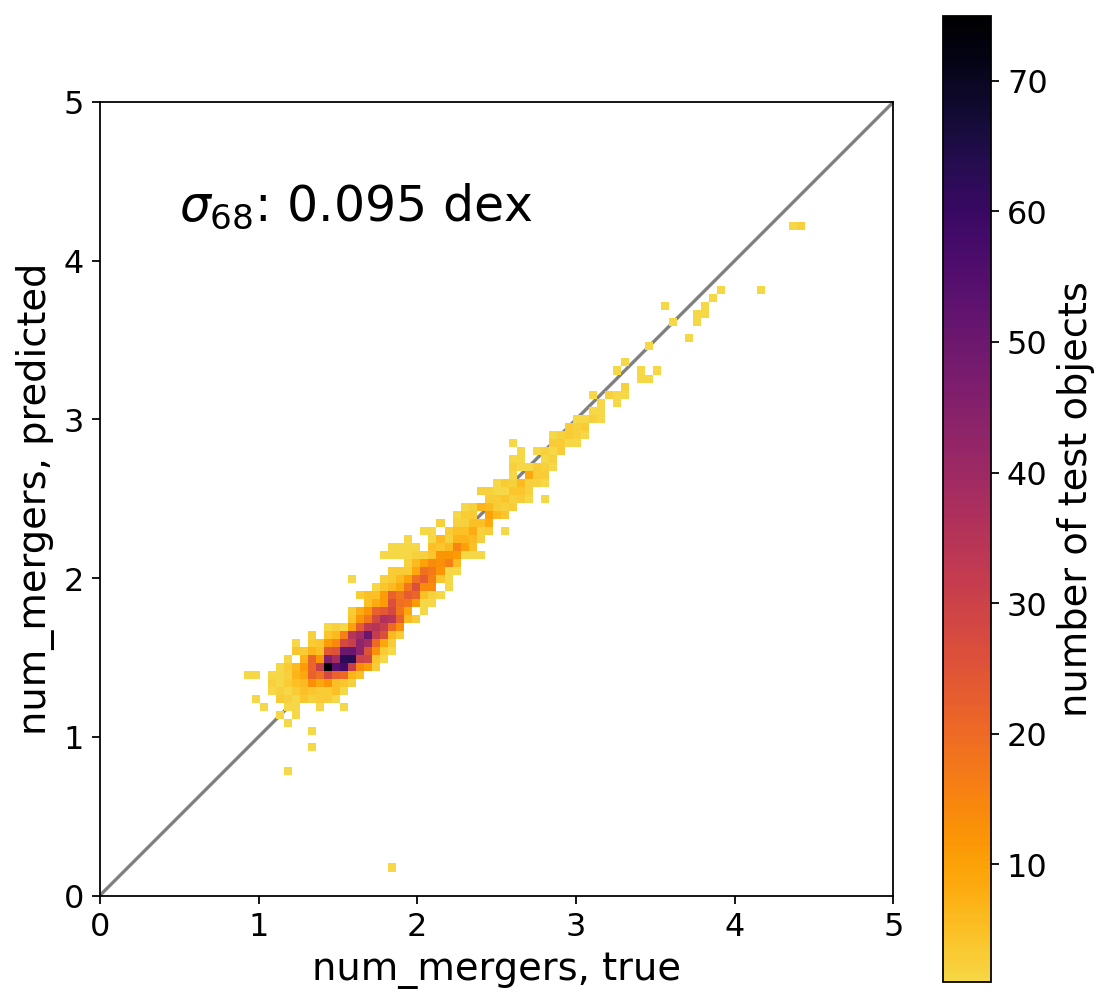

In [47]:
y_test_mult = y_test 
y_pred_mult = y_pred
error_nn, _ = utils.compute_error(y_test_mult, y_pred_mult, test_error_type='percentile')
error_str = fr"$\sigma_{{68}}$: {error_nn:.3f} dex"
plotter.plot_pred_vs_true_hist(y_label_name, y_test_mult, y_pred_mult, text_results=error_str,
                               x_lim=(0,5),  y_lim=(0,5))

# mstellar w cat+merger features

In [60]:
x_label_name = 'm_200m'
y_label_name = 'm_stellar'

feature_names = ['catalog_mergers_noaform']
fit_tags = [f'_{y_label_name}_nn_{feature_name}_epochs500_lr5e-05_hs128' for feature_name in feature_names]

y_pred_arr = []
text_results_arr = []
    
y = utils.get_y_vals(y_label_name, sim_reader)
y_test = y[idx_test] 
y_test_mult = y_test + log_mass_shift

for i, fit_tag in enumerate(fit_tags):
    print(fit_tag)
    
    x = x_dict[feature_names[i]]
    x_extra = x_extra_dict[feature_names[i]]
    if x is not None:
        x_test = x[idx_test]
    else:
        x_test = None
    if x_extra is not None:
        x_test_extra = x_extra[idx_test]
    else:
        x_test_extra = None
        
    fn_model = f'../models/models_{sim_name}/model_{sim_name}{halo_tag}{geo_tag}{scalar_tag}{fit_tag}.pt'

    nnfitter = NNFitter()
    nnfitter.load_model(fn_model)

    model_checkpoint = torch.load(fn_model)

    y_pred = nnfitter.predict(x_test, y_current=y_test_current, x_extra=x_test_extra)

    y_pred_mult = y_pred + log_mass_shift
    
    error_nn, _ = utils.compute_error(y_test_mult, y_pred_mult, test_error_type='percentile')
    error_str = fr"$\sigma_{{68}}$: {error_nn:.3f} dex"

    
    y_pred_arr.append(y_pred_mult)
    text_results_arr.append(error_str)

_m_stellar_nn_catalog_mergers_noaform_epochs500_lr5e-05_hs128


KeyError: 'catalog_mergers_noaform'